# This is my jam Project
## Description 
NEED TO DESCRIBE THE DATASET.

The initial research questions was initially the following:
(1) The project will study the properties of the network built on top of the ”follow” links between users. It will put these properties in perspective with the spread of Jam over time in the network;
(2) Considering the features provided by the dataset and possibly supplementary informations provided by the Spotify API, another network explaining at best the spreading of jams over itself will be built. It will be also studied with spectral graph theory;
(3) Based on the knowledge of the dataset acquired during the analysis of both graphs, a recommender system for users of the network will be built based on graph theory.

However the final result of this project is different. First the study of the spread of Jams started but quickly it has been shown that the greatest number of Jam of a song was very little in comparison with the size of the social network. Although this happenned sufficiently soon during the projet some signal analysis has been tried with these data. Primary analysis of Jams spread over networks is presented in the Data Exploration part. 

Afterward Spotify API has been used to collect more information about the songs shared, thanks to that it was possible to define a new research question. This question is related to genre of music shared by people over the  social network. More precisely the purpose of the analysis is to look for community in the graph where people tends to have similar taste in term of music genre.

Finally using the last research question analysed it has been possible to analyse a predictor of the taste of people based on graph prediction algorithms.

## Data Acquisition And Data Cleaning
In this part we first load and clean the 3 datasets provided by MyJam network. Then we complete these data with Spotify informations.

In [1]:
%matplotlib inline
#importing all relevant packages
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters, plotting
import pickle

plt.rcParams['figure.figsize'] = (10, 10)
plotting.BACKEND = 'matplotlib'

#Setting style for plotting
sns.set_style('whitegrid')
sns.set_palette('cubehelix',3)

2018-01-21 21:21:44,739:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dyn

First we need to load the data for the project. The data is stored in three tsv files:
- jams.tsc: All jams created including some matadata about the jam
- followers.tsv: Who follows who
- likes.tv: Who has liked which jams

To understand and work with this data we will load it into dataframes and do some data cleaning

In [3]:
data= pd.read_csv('archive/jams.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

b'Skipping line 7872: expected 7 fields, saw 8\nSkipping line 11730: expected 7 fields, saw 9\nSkipping line 14131: expected 7 fields, saw 8\nSkipping line 58054: expected 7 fields, saw 8\nSkipping line 58754: expected 7 fields, saw 8\n'
b'Skipping line 847129: expected 7 fields, saw 8\n'
b'Skipping line 1091153: expected 7 fields, saw 8\nSkipping line 1175375: expected 7 fields, saw 8\n'
b'Skipping line 1225935: expected 7 fields, saw 8\nSkipping line 1255357: expected 7 fields, saw 8\nSkipping line 1279671: expected 7 fields, saw 8\n'
b'Skipping line 1330675: expected 7 fields, saw 8\n'
b'Skipping line 1448033: expected 7 fields, saw 8\nSkipping line 1543893: expected 7 fields, saw 8\n'
b'Skipping line 1579569: expected 7 fields, saw 8\nSkipping line 1612448: expected 7 fields, saw 8\n'
b'Skipping line 1784588: expected 7 fields, saw 8\n'


Importing the data was only possible if we allowed for bad lines to be skipped, however we see that it is less that 20 and are not very concerned with these lines as we assume it will not make a difference in the later analysis. 

By manually inspecting the raw data it is not difficult to find lines that are being read in a wrong way In parts of the data there are newlines and \t separators that are not placed correctly. This results in empty lines and lines where the data has been shifted to either side and slip between several lines. In order to figure out how many lines are concerned with these kinds of errors we sort the dataframe on the date and thus all the lines where the format of the field creation_date is not in a date format will appear at the end. We decided to simply remove all these lines so that the ones left are the ones read correctly. It should be noted that most of the information could have been recovered by manually inspecting and removing places with faulty new lines and tabs. However, we decided that it would be too time consuming for the project. It is observed that at maximum a few 100 jams have been removed (that potentially could have been restored) and in comparison with the more than 2.000.000 jams that are part of the analysis, this is very unlikely to have any real influence on the later analysis.

Furthermore, it is observed that some song titles and artists are NaN's.This might be due to some fault in the data collection, but could also simply be because it has been possible to create jams without specifying the artist or title and therefore we leave these jams in the dataset.

We see that all jam id's are unique and that all lines contain a user id and a creaton date.

In [4]:
data = data.sort_values(by='creation_date')[0:2090068-605]

description = data.describe()
description[0:2]

,jam_id,user_id,artist,title,creation_date,link,spotify_uri
count,2089463,2089463,2088228,2089077,2089463,2072585,1479763
unique,2089463,132297,240051,568426,1492,950444,401193


The social connections (network) is described by the followint dataframe where all followers are linked to the users they follow. In this dataframe we observe no values that seem faulty.

In [5]:
net = pd.read_csv('archive/followers.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
net.head(5)

,followed_user_id,follower_user_id
0,b99ebf68a8d93f024e56c65e2f949b57,1ebda3c5e05265626ab18401fb33a90a
1,c1066039fa61eede113878259c1222d1,1ebda3c5e05265626ab18401fb33a90a
2,d8a96caeef5c7d8dbdc9cec28aa9c044,1ebda3c5e05265626ab18401fb33a90a
3,2969c319775d884b860a897ba9d6156f,1ebda3c5e05265626ab18401fb33a90a
4,ff58e67948917e0ff71ba4b33e158365,1ebda3c5e05265626ab18401fb33a90a


The last dataframe contains all the likes and thus each user is linked to the jam they liked. This dataframe also seem to contain no faulty values.

In [6]:
likes = pd.read_csv('archive/likes.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
likes.head()

,user_id,jam_id
0,c1066039fa61eede113878259c1222d1,5d2bc46196d7903a5580f0dbedc09610
1,b99ebf68a8d93f024e56c65e2f949b57,8940ff2e8e38c8f1a4676e09d152c0cd
2,c1066039fa61eede113878259c1222d1,4849f8c893a792032dbc15eb77cfd0cd
3,c1066039fa61eede113878259c1222d1,4020b45a4c6d5515a3b62c489e169828
4,b99ebf68a8d93f024e56c65e2f949b57,4849f8c893a792032dbc15eb77cfd0cd


Spotify API scraping and creation of one df which contains everything needed for the data exploration about jams.

## Data Exploration

### Jams' features main properties study

### Graph properties analysis of the natural social networks (Unweighted and weighted)

#### Unweighted social network

To explore the dataset in a graph context we first create a simle unweighted network.

To create a simple unweighted network we look at the net dataframe and add all the unique user id's as nodes to the network. Next we add edges between all the relevant nodes by going through the net dataframe.

In [7]:
followed = list(net['followed_user_id'].unique())
followers = list(net['follower_user_id'].unique())

nodes = list(set(followed+followers))

#creating the network with nodes
G = nx.Graph()
G.add_nodes_from(nodes)

#adding all edges
for i in tqdm(range(len(net))):
    if net['followed_user_id'].iloc[i] != net['follower_user_id'].iloc[i]:
        G.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)

100%|██████████| 1603404/1603404 [03:53<00:00, 6876.46it/s]


The first thing we need to examine is the components of the network. Since we need to work with a connected graph for the signal processing, we chose the largest connected component to continue working with.



In [10]:
nx.is_connected(G)

False

In [36]:
#we will keep the greatest component Gcc[0] for the further analysis
Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print('The number of components in the network is: {}'.format(len(Gcc)))
print('Thesize of the largest component in the network is: {}'.format(len(Gcc[0].nodes)))

The number of components in the network is: 1
Thesize of the largest component in the network is: 100518


It seems like many components and it is therefore important to examine the size of these before discarding all but the largest.

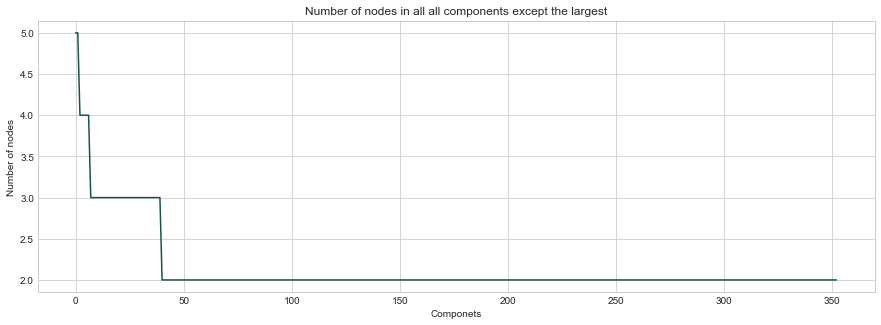

In [35]:
#number of nodes in all components except the largest
l=[]
for i in range(1,len(Gcc)):
    l.append(len(Gcc[i].nodes))
plt.figure(figsize=(15,5))
plt.plot(l);
plt.title('Number of nodes in all all components except the largest');
plt.xlabel('Componets');
plt.ylabel('Number of nodes');

Since most components only contain two nodes and the largest contain 5. It's reasonable to continue with just the largest component.

The unweigted network G has 100518 nodes.
The unweigted network G has 1294160 edges.
The nodes in G has an average degree of 25.75.


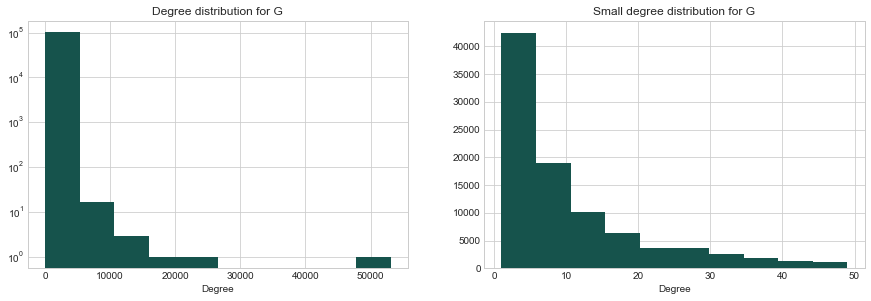

In [37]:
#keeping only the largest component
G = Gcc[0]

print('The unweigted network G has {} nodes.'.format(len(G.nodes())))
print('The unweigted network G has {} edges.'.format(G.size()))
print('The nodes in G has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G)).values()))/len(G.nodes())))

fig = plt.figure(1,figsize=(15,10))

#plotting degree distribution
degrees = np.array(list(dict(nx.degree(G)).values()))
plt.subplot(221)
plt.hist(degrees, log=True);
plt.title('Degree distribution for G');
plt.xlabel('Degree');

#plotting distribution for small degrees
small_degrees = degrees[degrees < 50]
plt.subplot(222)
plt.hist(small_degrees);
plt.title('Small degree distribution for G');
plt.xlabel('Degree');

Now we will try to detect communities in the network. If there are we will then try to analyze if communities share same music taste.

In [ ]:
comms = nx.algorithms.community.asyn_lpa_communities(G)

#### Weighted social network
In the later analysis when we want to observe how songs propagate through a network it is important to consider how well connected two given nodes are and not just that they are simply connected. If two users interact many times we assume that they are also more likely to be influenced by each other. Therfore we will create a weighted graph where the weights on the edges depend on the amount of times two users have liked each others jams.

Since the likes dataset only contains the id's of the user and the jam they liked and not the user_id of the person who jammed the song, we first need to merge these dataframes.

In [49]:
#merging likes and data
merge = likes.merge(data[['jam_id','user_id']],on='jam_id')
grouped = merge.groupby(['user_id_x','user_id_y']).count()
grouped.sort_values(by='jam_id',ascending=False).head()

,,jam_id
user_id_x,user_id_y,
8e01cba1a99a9eae7ffbb7bb76aac150,fd3292545fd8b2c8dcbdb86335052238,1723
a12e5a826d390a0a138c21841b8f34c7,fd3292545fd8b2c8dcbdb86335052238,1619
8eaf92d9023c44e657193e50f09e7725,fd3292545fd8b2c8dcbdb86335052238,1404
126932e6915c39fd6127c0c635461307,126932e6915c39fd6127c0c635461307,1307
dc87e7ab06a5aad596130c6966d2fe0c,fd3292545fd8b2c8dcbdb86335052238,1163


Since the merge dataframe here is sorted by the number of likes form user_x to user_y, we can see that the maximum number of t likes are around a 1000, however most of them are far lower.

In [39]:
G_w = G
for i in tqdm(range(len(merge))):
    if grouped.iloc[i].name[0] in G_w.nodes and grouped.iloc[i].name[1] in G_w.neighbors(grouped.iloc[i].name[0]):
            G_w[grouped.iloc[i].name[0]][grouped.iloc[i].name[1]]['weight'] += grouped.iloc[i]['jam_id']

100%|██████████| 1384506/1384506 [20:25<00:00, 1129.43it/s]


In [40]:
nx.write_gpickle(G_w,'G_w')

The weigted network G_w has 100518 nodes.
The weigted network G_w has 1294160 edges.
The nodes in G_w has an average degree of 123.00.


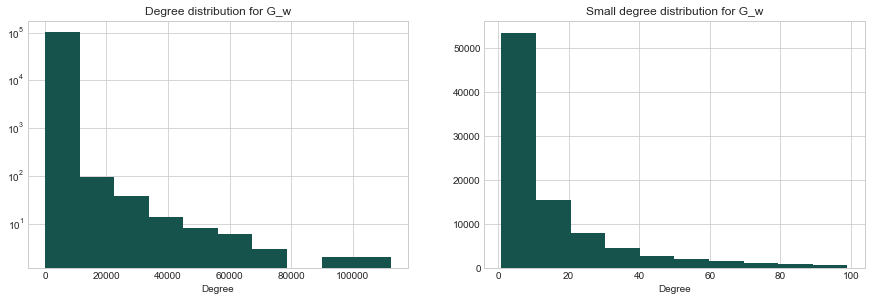

In [41]:

print('The weigted network G_w has {} nodes.'.format(len(G_w.nodes())))
print('The weigted network G_w has {} edges.'.format(G_w.size()))
print('The nodes in G_w has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_w,weight='weight')).values()))/len(G_w.nodes())))


fig = plt.figure(1,figsize=(15,10))

#pltotting degree distribution
degrees_w = np.array(list(dict(nx.degree(G_w,weight='weight')).values()))
plt.subplot(221)
plt.hist(degrees_w, log=True);
plt.title('Degree distribution for G_w');
plt.xlabel('Degree');

#plotting the small degrees
small_degrees_w = degrees_w[degrees_w < 100]
plt.subplot(222)
plt.hist(small_degrees_w);
plt.title('Small degree distribution for G_w');
plt.xlabel('Degree');

Again we see that even though the average degree is much higher than for the unweighted network most of the nodes still have very small degrees below 20. A few degrees have extremely high degrees around 100.000.

## Data Exploitation

## 4. The pruned network

We will now look at a pruned network where only nodes related to a given signal is kept. Later we will analyze the most relevant signals. We consider their relevance based on the amount of times the specific song has been jammed.

First we create a list containing the all the jammed songs sorted after the amount of times the song was jammed.

In [42]:
most_jammed = data[['jam_id','artist','title']].groupby(['artist','title']).count().sort_values(by='jam_id',ascending=False)

We then write a function to create any network with relevant weights.

In [50]:
def Create_network(artist,title):
    data_network = data.loc[(data.artist==artist) & (data.title==title)]
    nodes_network = data_network['user_id']
    G = nx.Graph()
    G.add_nodes_from(nodes_network.values)
    
    #adding nodes and edges of followers
    net_jammed = net[net['followed_user_id'].isin(nodes_network.values) & \
                     (net['follower_user_id'] != net['followed_user_id'])]
    for i in tqdm(range(len(net_jammed))):
        G.add_node(net['follower_user_id'].iloc[i])
        G.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)

    #adding weights
    jammers = merge[merge['user_id_x'].isin(list(G.nodes())) & (merge['user_id_y'].isin(list(G.nodes())))]
    grouped_jammers = jammers.groupby(['user_id_x','user_id_y']).count()
    for i in tqdm(range(len(grouped_jammers))):
        if grouped_jammers.iloc[i].name[1] in G.neighbors(grouped_jammers.iloc[i].name[0]):
            G[grouped_jammers.iloc[i].name[0]][grouped_jammers.iloc[i].name[1]]['weight'] += \
            np.log(grouped_jammers.iloc[i]['jam_id'])
            
    return G

### Example: The most jammed song

In [51]:
G_grimes = Create_network('Grimes','Oblivion')

100%|██████████| 412715/412715 [02:51<00:00, 2407.05it/s]


In [52]:
nx.write_gpickle(G_grimes,'G_grimes')

In [ ]:
G_grimes = nx.read_gpickle('G_grimes')

In [54]:
#removing nodes with degree below 20
G_grimes_nodes = list(G_grimes.nodes())
G_grimes_degrees = G_grimes.degree(G_grimes_nodes,weight='weight')

for i in G_grimes_nodes:
    if G_grimes.degree[i] < 20:
        G_grimes.remove_node(i)

In [55]:
print('The weigted network G_grimes has {} nodes.'.format(len(G_grimes.nodes())))
print('The weigted network G_grimes has {} edges.'.format(G_grimes.size()))
print('The nodes in G_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_grimes,weight='weight')).values()))/len(G_grimes.nodes())))

The weigted network G_grimes has 576 nodes.
The weigted network G_grimes has 11846 edges.
The nodes in G_grimes has an average degree of 78.95.


## 5. signal



In [63]:
def create_signal(network,artist,title):
    network_nodes = network.nodes()
    #Get relevant data
    data_n = data[(data.artist==artist) & (data.title==title)]
    #keep only two columns
    data_n = data_n[['user_id','creation_date']]
    #keep only ones in the node list
    data_n = data_n[(data_n.user_id.isin(network_nodes))]
    #initialize signal
    data_n['signal'] = 0
    data_n['signal'].iloc[0] = 1
    #change format to datetime
    data_n['creation_date'] = data_n['creation_date'].apply(pd.to_datetime)
    
    #add signal as amount of days from the day of the first jam
    for i in tqdm(range(1,len(data_n['user_id']))):
        a = data_n['creation_date'].iloc[i]-data_n['creation_date'].iloc[0]
        data_n['signal'].iloc[i] = a.days
    
    #adding extra data, the nodes that are user that didnt share the song
    data_n_extra = pd.DataFrame(columns=data_n.columns)
    data_n_extra['user_id'] = network_nodes
    #set their signal
    data_n_extra['signal']=2000   
    #append all data
    data_n = data_n.append(data_n_extra)
   
    #drop duplicates, but since the ones in the signal are at the top they will be kept
    data_n = data_n.drop_duplicates('user_id',keep='first')
    
    #sort the dataframe to be in the same order as the nodes
    data_n['user_cat'] = pd.Categorical(data_n['user_id'],categories=list(network.nodes()),ordered=True)
    data_n = data_n.sort_values('user_cat')
    
    return data_n

### Example: the most jammed song (continued)

In [64]:
#create signal for Grimes Oblivion
data_grimes = create_signal(G_grimes,'Grimes','Oblivion')

C:\Users\Charlotte\Anaconda3\envs\ntds\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 22/22 [00:12<00:00,  1.80it/s]


In order to analyze the created signal we compute the Laplacian and fourier basis:

In [71]:
#create graph
G_grimes_adj = nx.adjacency_matrix(G_grimes)
G_grimes_f = graphs.Graph(G_grimes_adj)

#compute fourier
G_grimes_f.compute_laplacian('normalized')
G_grimes_f.compute_fourier_basis()

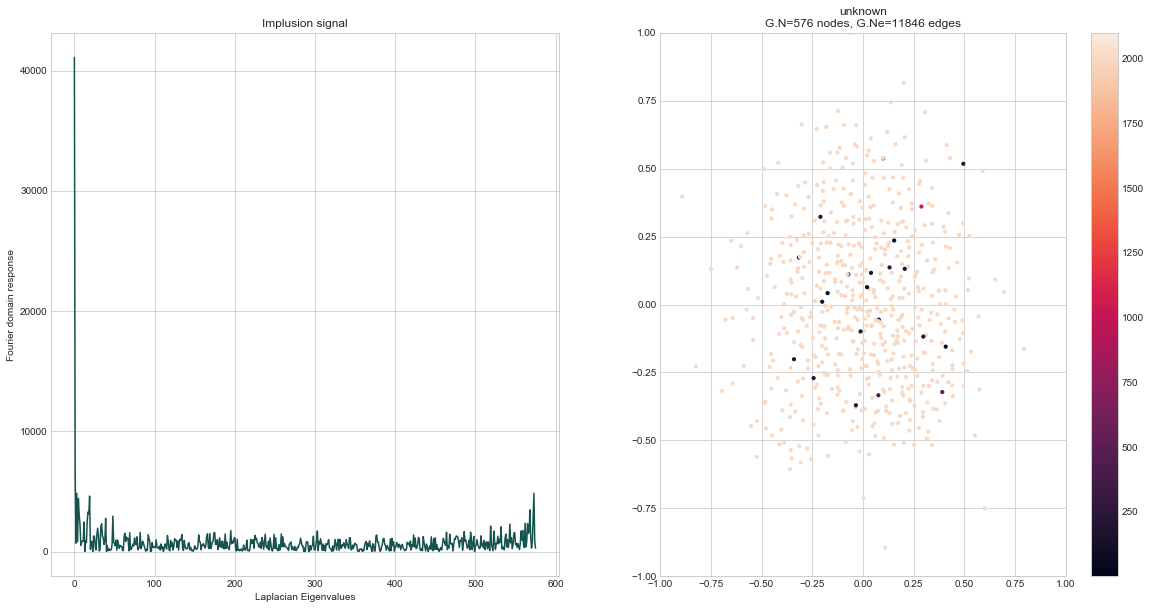

In [72]:
#plot the signal
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

signal = data_grimes['signal'].values
#G_grimes_f.set_coordinates(G_grimes_f.U[:,1:3])
G_grimes_f.set_coordinates()
G_grimes_f.plot_signal(signal,vertex_size=10, ax=axes[1])
plt.axis([-1,1,-1,1])

axes[0].plot(np.abs(G_grimes_f.gft(signal)))
axes[0].set_xlabel('Laplacian Eigenvalues')
axes[0].set_ylabel('Fourier domain response')
axes[0].set_title('Implusion signal')

### Jams spread over time in different networks.

Put what is in the other notebook and comment on the result and the reason why we decided to change our research question.

In [73]:
def getInsightSongJam(artist, song, fig, axes, graph):
    print('The weigted network G_grimes has {} nodes.'.format(len(graph.nodes())))
    print('The weigted network G_grimes has {} edges.'.format(graph.size()))
    print('The nodes in G_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(graph,weight='weight')).values()))/len(graph.nodes())))
    if not(nx.is_connected(graph)):
        #keeping the largest connected component
        graph=sorted(nx.connected_component_subgraphs(graph), key = len, reverse=True)
        graph = graph[0]
        print('The weigted network Gcc_grimes has {} nodes.'.format(len(graph.nodes())))
        print('The weigted network Gcc_grimes has {} edges.'.format(graph.size()))
        print('The nodes in Gcc_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(graph,weight='weight')).values()))/len(G_grimes_small.nodes())))
    #Get relevant data
    data_grimes = data.loc[(data.artist==artist) & (data.title==song)]
    #keep only two columns
    data_grimes = data_grimes[['user_id','creation_date']]
    #keep only ones in the node list
    data_grimes = data_grimes[(data_grimes.user_id.isin(graph.nodes()))]
    #change format to datetime
    data_grimes['creation_date'] = data_grimes['creation_date'].apply(pd.to_datetime)
    data_grimes.drop_duplicates(subset='user_id', inplace=True)
    data_grimes.reset_index(inplace=True)
    #initialize signal
    data_grimes['signal'] = 0
    data_grimes.loc[0, 'signal'] = 1

    #add signal has amount of days from the day of the first jam
    for i in range(1, data_grimes.shape[0]):
        a = data_grimes['creation_date'].iloc[i] - data_grimes['creation_date'].iloc[0]
        b = data_grimes['creation_date'].iloc[0] - data_grimes['creation_date'].iloc[i]
        data_grimes.loc[i, 'signal'] = a.days*24 + a.seconds/3600

    #create graph
    graph_f = graphs.Graph(nx.adjacency_matrix(graph))
    #sort the dataframe to be in the same order as the nodes
    data_grimes['user_cat'] = pd.Categorical(data_grimes['user_id'],categories=list(graph.nodes()),ordered=True)
    data_grimes.sort_values('user_cat', inplace=True)
    #compute fourier
    graph_f.compute_laplacian('normalized')
    graph_f.compute_fourier_basis()


    #plot the signal
    signal = data_grimes['signal'].values
    graph_f.set_coordinates(graph_f.U[:, [1, 2]])
    graph_f.plot_signal(signal,vertex_size=10, ax=axes[1])
    scale = 1
    plt.axis([-scale,scale,-scale,scale])

    axes[0].plot(np.abs(graph_f.gft(signal)))
    axes[0].set_xlabel('Laplacian Eigenvalues')
    axes[0].set_ylabel('Fourier domain response')
    axes[0].set_title('Implusion signal')
    
    # Compute the signal smoothness with gradient
    smoothness = signal.T @ graph_f.L @ signal / np.linalg.norm(signal)**2
    print("Signal gradient: %f" % smoothness)
    
    # Compute the suffles signal smoothness with gradient
    smoothness = 0
    for i in range(5):
        shuffled_signal = data_grimes.sample(frac=1)['signal'].values
        smoothness += shuffled_signal.T @ graph_f.L @ shuffled_signal / (5 * np.linalg.norm(shuffled_signal)**2)
    print("Shuffled signal gradient: %f" % smoothness)

('Grimes', 'Oblivion')


100%|██████████| 412715/412715 [04:06<00:00, 1672.24it/s]


The weigted network G_grimes has 12488 nodes.
The weigted network G_grimes has 38940 edges.
The nodes in G_grimes has an average degree of 10.86.
The weigted network Gcc_grimes has 11869 nodes.
The weigted network Gcc_grimes has 38937 edges.
The nodes in Gcc_grimes has an average degree of 10.86.


2018-01-22 00:29:21,184:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (11869 x 11869) may take some time.


ValueError: Signal length is 239, should be G.N = 11869.

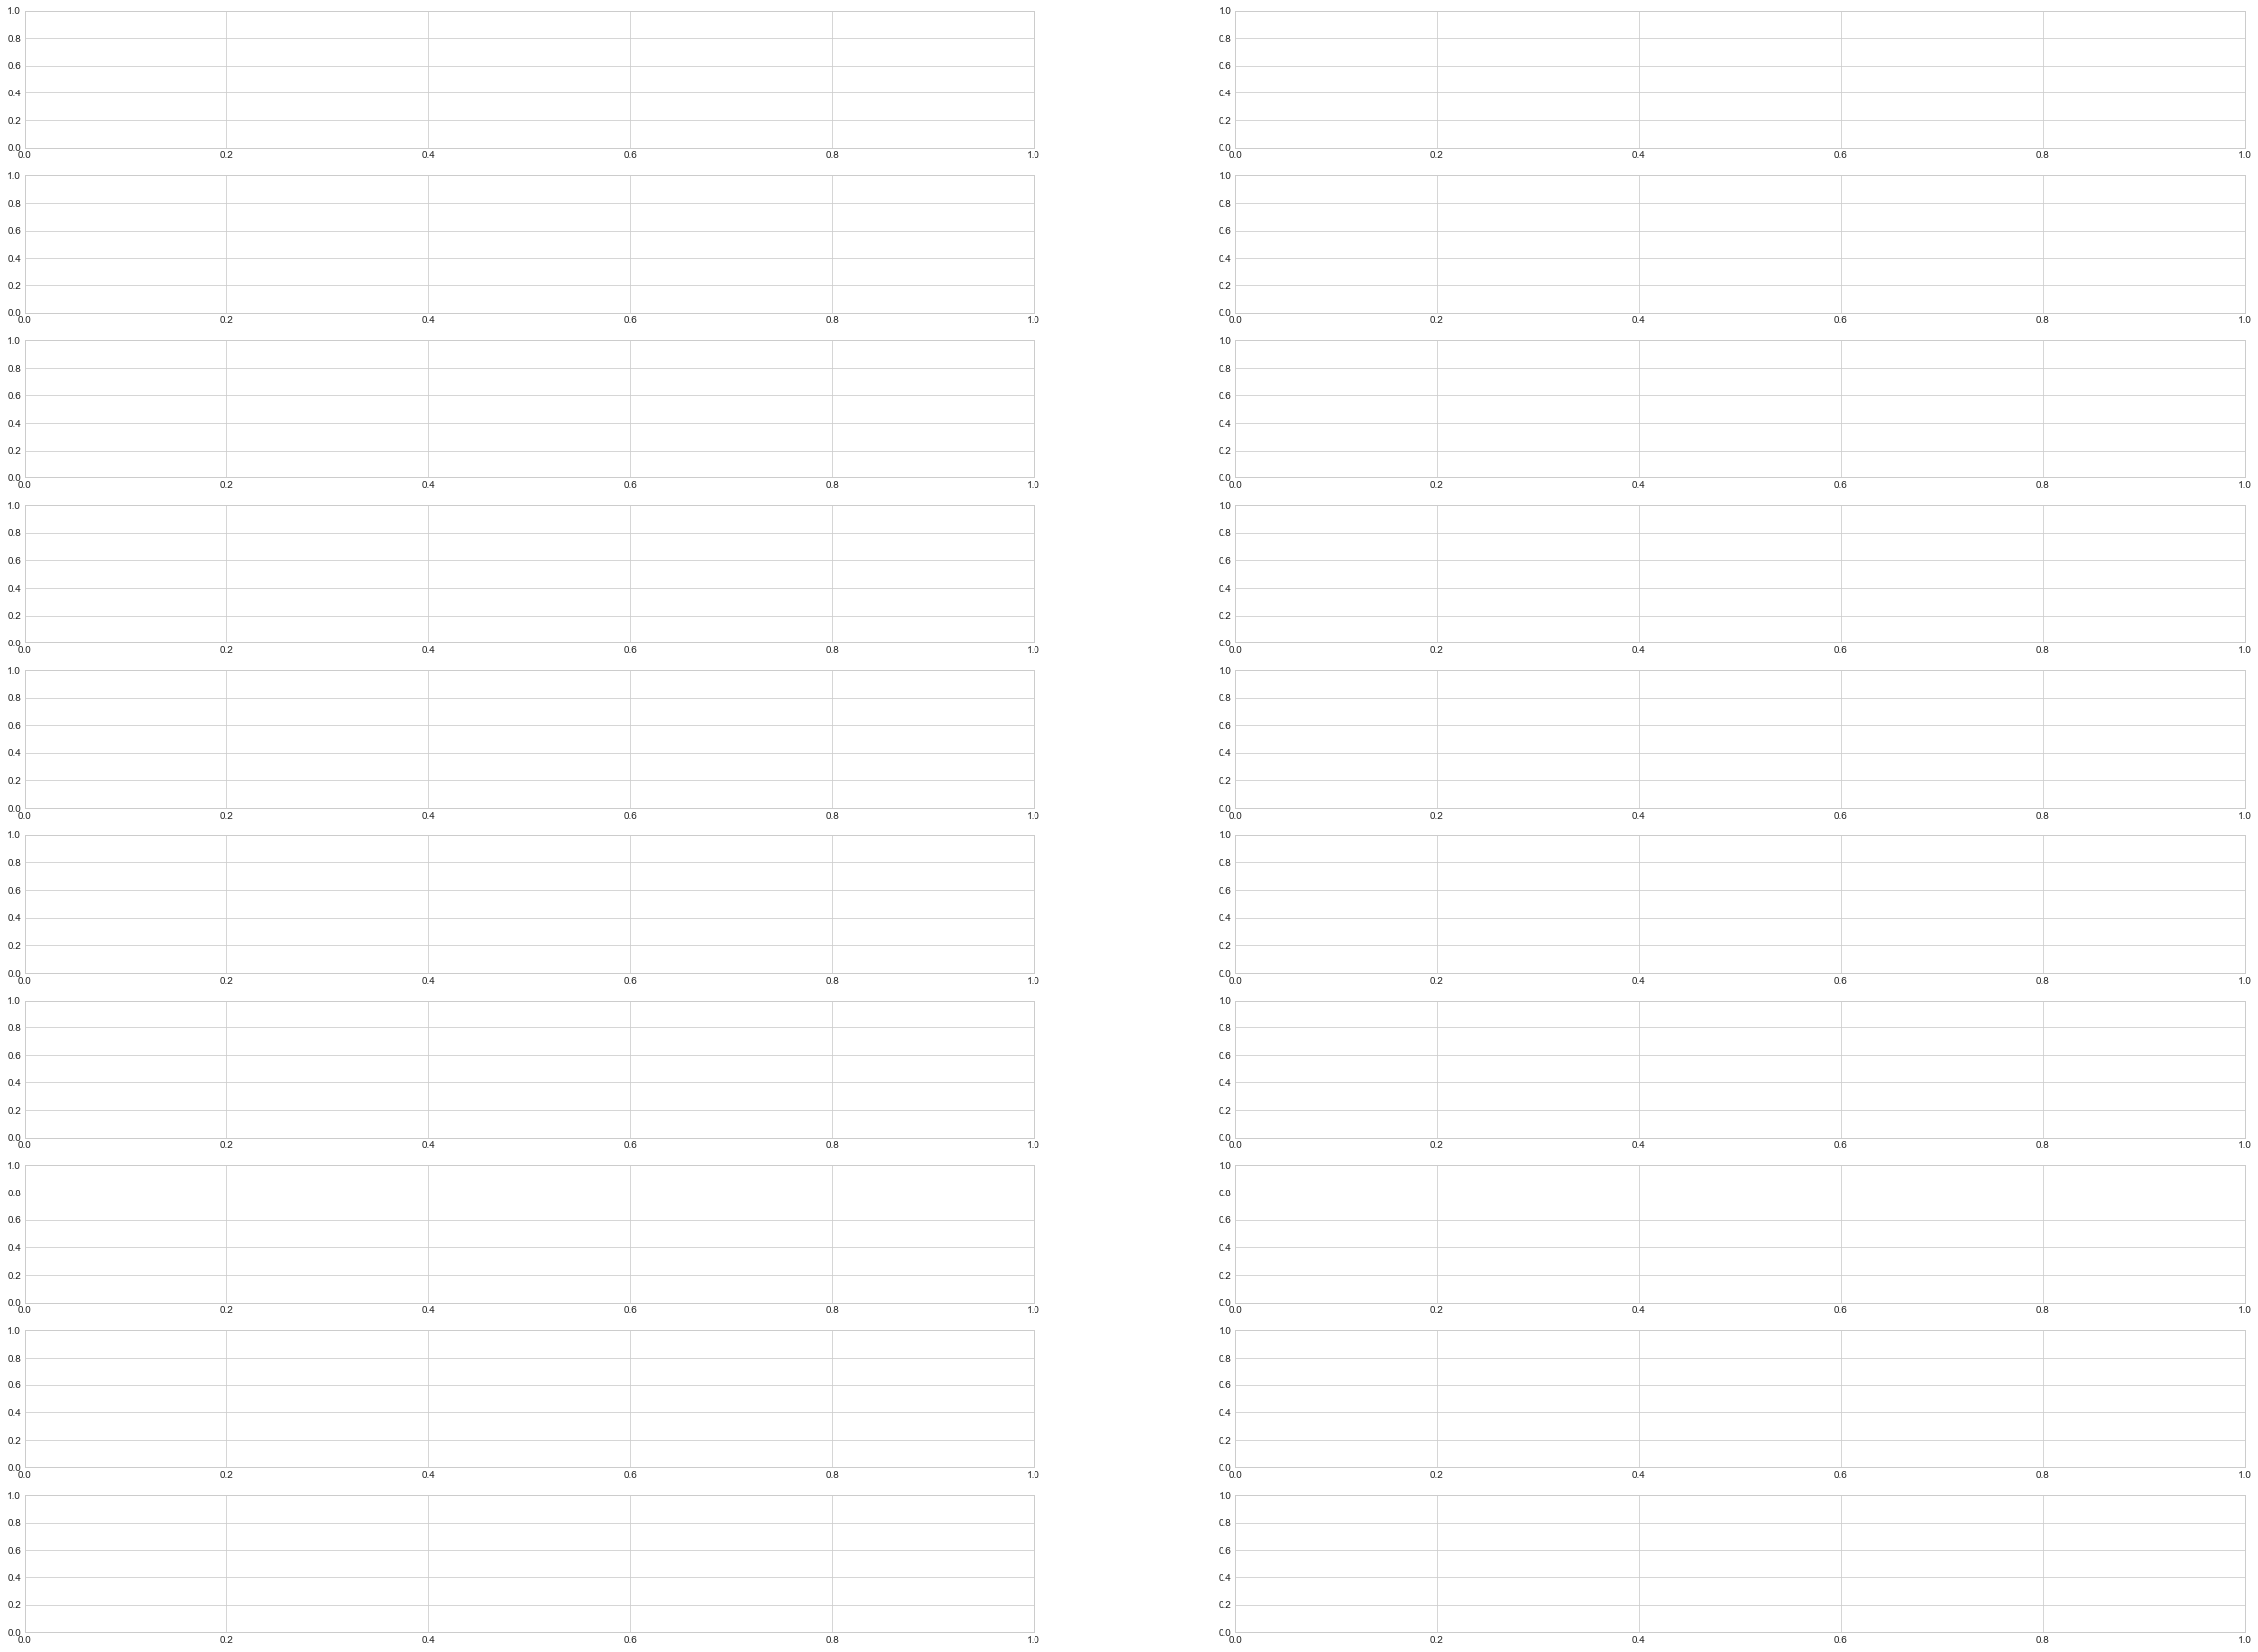

In [76]:
fig, axes = plt.subplots(10, 2, figsize=(40, 30))
#for most_jammed
#getInsightSongJam('Grimes', 'Oblivion', fig, axes)
i = 0
for id, row in most_jammed.iloc[:10].iterrows():
    print(row.name[0:2])
    G_grimes_small = Create_network(row.name[0], row.name[1])
    getInsightSongJam(row.name[0], row.name[1], fig, axes[i, :], G_grimes_small)
    i+=1

### Genre of songs community in different networks.

In [46]:
#pickle.load('pickles/artists_ntds.pkl')
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )
#artist.artist_genres.astype(str, inplace=True)
all_genre = set()
genre_graph = nx.Graph()
for genre in artist.artist_genres.values:
    all_genre = all_genre.union(set(genre))
all_genre = list(all_genre)
genre_graph = nx.Graph()
genre_graph.add_nodes_from(all_genre)
for genres in tqdm(artist.artist_genres.values):
    for i in range(len(genres)):
        for j in range(i + 1, len(genres)):
            if genre_graph.has_edge(genres[i], genres[j]):
                genre_graph[genres[i]][genres[j]]['weight'] += 1
            else:
                genre_graph.add_edge(genres[i], genres[j], weight=1)


100%|██████████| 68620/68620 [00:01<00:00, 40470.16it/s]


<class 'numpy.matrixlib.defmatrix.matrix'>
[[1836    1   27 ...,    2    4    5]]


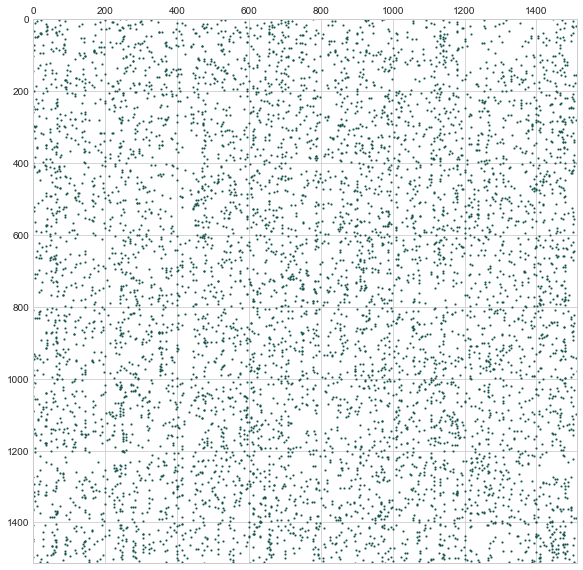

In [38]:
plt.figure(figsize=(10,10))
weights = nx.adjacency_matrix(genre_graph).todense()
print(type(weights))
NEIGHBORS = 5
# Find sorted indices for each row
sorted_row_idx = np.argsort(weights, axis=1)
for row in range(len(sorted_row_idx)):
    weights[row, sorted_row_idx[row, :-NEIGHBORS]] = 0
plt.spy(weights,markersize=1);

if np.sum(np.abs(weights-weights.transpose())) != 0:
    # Make W is symmetric
    bigger = weights.transpose() > weights
    weights = weights - weights*bigger + weights.transpose()*bigger


In [48]:
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )
genre_graph = nx.Graph()
all_genres = artist.artist_genres.values

for genre in tqdm(all_genre):
    artist[genre] = 0

for i in tqdm(range(len(all_genres))):
    genres = all_genres[i]
    artist.loc[i, genres] = 1

artist.columns

100%|██████████| 68620/68620 [03:58<00:00, 287.12it/s]


Index(['artist_id', 'artist_genres', 'gangster rap', 'anime score',
       'bossa nova', 'rap metal', 'indian rock', 'spanish hip hop',
       'world meditation', 'halloween',
       ...
       'twee pop', 'russian rock', 'hip pop', 'blackgaze', 'hungarian pop',
       'kabarett', 'gothic post-punk', 'new jack swing', 'hard minimal techno',
       'hip hop'],
      dtype='object', length=1515)

In [51]:
genres_feature = artist.loc[:, artist.columns[2:]]
genre_f = genres_feature.transpose()
genre_f.head()

,0,1,2,3,4,5,6,7,8,9,...,68610,68611,68612,68613,68614,68615,68616,68617,68618,68619
gangster rap,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anime score,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bossa nova,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rap metal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
indian rock,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
from sklearn.cluster import KMeans
distances = []
for nb_cluster in range(1, 10):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_jobs=5).fit(genre_f)
    distances.append(kmeans.inertia_)


In [65]:
for nb_cluster in range(11, 20):
    print(nb_cluster)
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_jobs=5).fit(genre_f)
    distances.append(kmeans.inertia_)

11
12
13
14
15
16
17
18
19


[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]


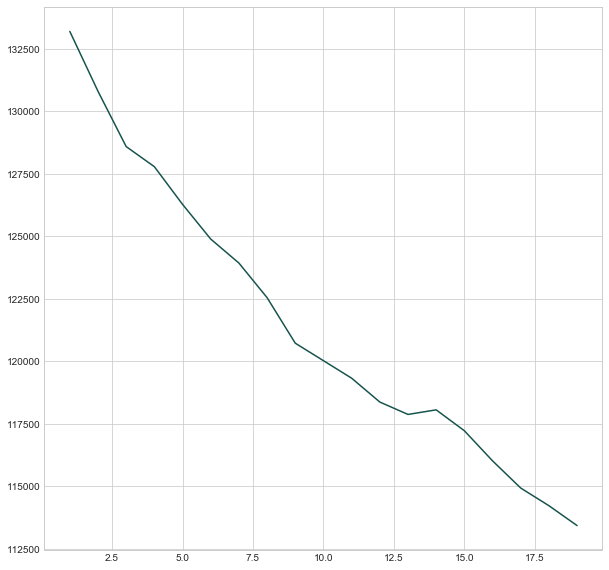

In [69]:
a = list(range(1, 10))
a += list(range(11, 20))
print(a)
plt.plot(a, distances)

In [ ]:
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )

In [ ]:
all_genres = artist.artist_genres.values

all_genre = set()
genre_graph = nx.Graph()
for genre in artist.artist_genres.values:
    all_genre = all_genre.union(set(genre))
all_genre = list(all_genre)

for genre in tqdm(all_genre):
    artist[genre] = 0

for i in tqdm(range(len(all_genres))):
    genres = all_genres[i]
    artist.loc[i, genres] = 1

In [ ]:
#retrieve all major genres
genres = artist.columns
genres_other = set(artist.columns[2:])
todrop = []
for i in (["pop","rock","blues","jazz","hip hop","electro","indie","folk","rap","r&b","soul","metal","techno","mellow","dance",]):
    genre_new = [s for s in genres if i in s]
    artist_new = artist[genre_new].max(axis=1)
    artist[i] = artist_new
    todrop += genre_new
    genres_other = genres_other - (set(genre_new))
    if i in todrop:
        todrop.remove(i)
artist = artist.drop(todrop,axis=1)

In [ ]:
#create column for other gneres
artist_other = artist[list(genres_other)].max(axis=1)
artist['others'] = artist_other
artist = artist.drop(list(genres_other),axis=1)

#create column for artist with no genre
genres_red = artist.columns[2:]
artist_none = 1 - artist[genres_red].max(axis=1)
artist['none'] = artist_none

#Show the amount of songs in each genre
genre_f =artist.loc[:, artist.columns[2:]].transpose()
genre_total = genre_f.sum(axis=1)
genre_total.sort_values(ascending=False)

In [ ]:
#connecting artist_id's with the spotify_uri and through that with the full dataframe
songs = pickle.load(open('pickles/songs_ntds.pkl',"rb"))
data_genre = data.merge(songs, on='spotify_uri').merge(artist, on='artist_id')
#retrieving the fraction of jammed songs by one user within each genre
data_genre = data_genre.groupby('user_id').sum()
data_genre = (data_genre.T /data_genre.sum(axis=1)).T

pickle.dump(data_genre,open('data_genre',"wb"))

## Conclusion